### Solar Meteorology Project  : Transposition Modelling (QC) of solar radiation measurements  ( ☕)

In [2]:
#Importing all the dependencies required for doing the simulation
import pandas as pd
import matplotlib.pyplot as plt
from pvlib import location
from pvlib import irradiance
import h5py
import numpy as np
import pvlib

### Transposition Modelling

In [23]:
# Take GHI,DNI and DHI from the h5 file and return a dataframe with GTI and (POA) plane of array(using pvlib.irradianceget_total_irradiance())
# using irradiance.get_total irradiance of pvlib module

#Input of the function are both strings
def get_transposition(site_location, date):
    #Read the h5 file using the input of the function
    h5 = h5py.File(f'../Project/eye2sky/{site_location}/{date}/{site_location}_{date}.l1.h5','r') #Read the h5 file
    #h5.visititems(print) #Prints all the elements in the h5file
    #print(h5['60s/ghi.1'][:]) Accessing the whole array
    tz = 'UTC'
    #The SolarPosition function needs the latitude and latitude
    if site_location=='OLUOL':
        lat, lon = 53.15342,8.16191
    elif site_location=='PVNOR':
        lat, lon= 53.57737,7.23155
    elif site_location=='OLDON':
        lat, lon= 53.14638,8.21734
    elif site_location=='LEEER':
        lat, lon= 53.22173,7.446681
    elif site_location=='OLCLO':
        lat, lon= 53.112004,8.210042  
    site = location.Location(lat, lon, tz=tz)
              
    #Create the datetime index by converting the already existing datetime index of the h5 file into a pandas datetime object
    # which is needed as a input for solar position
    times = pd.to_datetime(h5['60s/datetime'], unit='s') 
    #Adding timezone information to the times(pandas date time object)
    times = times.tz_localize(tz) 
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site.get_solarposition(times=times)
    irradiance_data = {
        'GTI': h5['60s/gti_30_180.1'][:],
    }
    # Calculate extra terrestrial radiation for hadavies model
    dni_extra = irradiance.get_extra_radiation(pd.DatetimeIndex(times)) #Haydavies model requies this extra component
    models = ['isotropic', 'klucher', 'haydavies', 'reindl', 'perez'] #There are five transposition models available

    for model in models:
        model_irradiance = irradiance.get_total_irradiance(    # Use the get_total_irradiance function to transpose the GHI to POA
            surface_tilt=30,
            surface_azimuth=180,
            dni=h5['60s/dni.1'][:],
            ghi=h5['60s/ghi.1'][:],
            dhi=h5['60s/dhi.1'][:],
            solar_zenith=solar_position['apparent_zenith'],
            solar_azimuth=solar_position['azimuth'],
            dni_extra=dni_extra,
            model=model
        )
        irradiance_data[f'POA_{model}'] = model_irradiance['poa_global']
    # Return DataFrame with only GTI and POA
    
    return pd.DataFrame(irradiance_data)

In [4]:
dates=['20200127','20200205','20200218','20200401','20200413','20200525','20200709','20200720','20200810','20200921','20200924','20201003']

def calculate_irradiance_for_dates(site_location, dates):
    all_results = []  # To store results for all dates

    for date in dates:
        result = get_transposition(site_location, date)
        all_results.append(result)

    combined_results = pd.concat(all_results, axis=0)  # Concatenate results for all dates
    return combined_results

site_locations = ['LEEER', 'OLCLO', 'OLDON', 'OLUOL', 'PVNOR']
GTI_Transposiiton_all = pd.concat([calculate_irradiance_for_dates(location, dates).reset_index(drop=True) for location in site_locations]).reset_index(drop=True) #Reduced Code


In [5]:
GTI_Transposiiton_all['E_M1']=GTI_Transposiiton_all['POA_isotropic']-GTI_Transposiiton_all['GTI']
GTI_Transposiiton_all['E_M2']=GTI_Transposiiton_all['POA_klucher']-GTI_Transposiiton_all['GTI']
GTI_Transposiiton_all['E_M3']=GTI_Transposiiton_all['POA_haydavies']-GTI_Transposiiton_all['GTI']
GTI_Transposiiton_all['E_M4']=GTI_Transposiiton_all['POA_reindl']-GTI_Transposiiton_all['GTI']
GTI_Transposiiton_all['E_M5']=GTI_Transposiiton_all['POA_perez']-GTI_Transposiiton_all['GTI']
bias_GTI_Transposiiton_all_m1 = np.mean(GTI_Transposiiton_all['E_M1']) #bias = np.mean(err)
bias_GTI_Transposiiton_all_m2= np.mean(GTI_Transposiiton_all['E_M2'])
bias_GTI_Transposiiton_all_m3= np.mean(GTI_Transposiiton_all['E_M3'])
bias_GTI_Transposiiton_all_m4= np.mean(GTI_Transposiiton_all['E_M4'])
bias_GTI_Transposiiton_all_m5= np.mean(GTI_Transposiiton_all['E_M5'])
rmse_GTI_Transposiiton_all_m1=np.sqrt(1/GTI_Transposiiton_all['E_M1'].size*np.sum(GTI_Transposiiton_all['E_M1']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_GTI_Transposiiton_all_m2=np.sqrt(1/GTI_Transposiiton_all['E_M2'].size*np.sum(GTI_Transposiiton_all['E_M2']**2))
rmse_GTI_Transposiiton_all_m3=np.sqrt(1/GTI_Transposiiton_all['E_M3'].size*np.sum(GTI_Transposiiton_all['E_M3']**2))
rmse_GTI_Transposiiton_all_m4=np.sqrt(1/GTI_Transposiiton_all['E_M4'].size*np.sum(GTI_Transposiiton_all['E_M4']**2))
rmse_GTI_Transposiiton_all_m5=np.sqrt(1/GTI_Transposiiton_all['E_M5'].size*np.sum(GTI_Transposiiton_all['E_M5']**2))

M1=[bias_GTI_Transposiiton_all_m1,rmse_GTI_Transposiiton_all_m1]
M2=[bias_GTI_Transposiiton_all_m2,rmse_GTI_Transposiiton_all_m2]
M3=[bias_GTI_Transposiiton_all_m3,rmse_GTI_Transposiiton_all_m3]
M4=[bias_GTI_Transposiiton_all_m4,rmse_GTI_Transposiiton_all_m4]
M5=[bias_GTI_Transposiiton_all_m5,rmse_GTI_Transposiiton_all_m5]
index=['isotropic','klucher','haydavies','reindl','perez']
Allsites_Transposition_Error_matrix=pd.DataFrame((M1,M2,M3,M4,M5),columns=['bias','rmse'],index=index)
Allsites_Transposition_Error_matrix.to_csv('Allsites_Transposition_Error_matrix.csv')
Allsites_Transposition_Error_matrix

,bias,rmse
isotropic,-5.525903,20.409653
klucher,1.131122,15.621031
haydavies,-0.429873,15.521817
reindl,-0.172596,15.456497
perez,1.094571,13.770423


## Comparing Decomposition Models

In [6]:
#Takes input as site_location and date and uses GHI from the H5 file and computes the DHI and DNI components
#  using different function from the library PVLIB. Returns a dataframe with DHI,DHI from the original file and also from the 
# 4 different decomposition models that were used in the modelling process
 
def get_decomposition(site_location, date):
    
    #Read the h5 file using the input of the function
    h5 = h5py.File(f'../Project/eye2sky/{site_location}/{date}/{site_location}_{date}.l1.h5','r') #Read the h5 file
    
    #h5.visititems(print) #Prints all the elements in the h5file
    #print(h5['60s/ghi.1'][:]) Accessing the whole array
    tz = 'UTC'
    #The SolarPosition function needs the latitude and latitude
    if site_location=='OLUOL':
        lat, lon = 53.15342,8.16191
    elif site_location=='PVNOR':
        lat, lon= 53.57737,7.23155
    elif site_location=='OLDON':
        lat, lon= 53.14638,8.21734
    elif site_location=='LEEER':
        lat, lon= 53.22173,7.446681
    elif site_location=='OLCLO':
        lat, lon= 53.112004,8.210042  
    site = location.Location(lat, lon, tz=tz)

    #Create the datetime index by converting the already existing datetime index of the h5 file into a pandas datetime object
    # which is needed as a input for solar position
    times = pd.to_datetime(h5['60s/datetime'], unit='s') 
    #Adding timezone information to the times(pandas date time object)
    times = times.tz_localize(tz) 
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site.get_solarposition(times=times)
    dni_extra = irradiance.get_extra_radiation(pd.DatetimeIndex(times))


    # Calculate the zenith for the Erbs model
    zenith = solar_position['apparent_zenith']

    results_df = pd.DataFrame(index=times)
    results_df['DHI'] = h5['60s/dhi.1'][:]
    results_df['DNI'] = h5['60s/dni.1'][:]

    erbs = pvlib.irradiance.erbs(
        ghi = h5['60s/ghi.1'][:],
        zenith=solar_position['apparent_zenith'],
        datetime_or_doy=times)
    
    results_df['DHI_erbs'] = erbs['dhi']
    results_df['DNI_erbs'] = erbs['dni']

   
    louche = pvlib.irradiance.louche(ghi=h5['60s/ghi.1'][:],solar_zenith=solar_position['apparent_zenith'],
    datetime_or_doy=times)
    results_df['DHI_louche']=louche['dhi']
    results_df['DNI_louche']=louche['dni']

   
    m = pvlib.irradiance.orgill_hollands(ghi=h5['60s/ghi.1'][:],zenith=solar_position['apparent_zenith'],
    datetime_or_doy=times)
    results_df['DHI_orgill_hollands']=m['dhi']
    results_df['DNI_orgill_hollands']=m['dni']

    boland = pvlib.irradiance.boland(ghi=h5['60s/ghi.1'][:],solar_zenith=solar_position['apparent_zenith'],
        datetime_or_doy=times)
    results_df['DHI_boland']=boland['dhi']
    results_df['DNI_boland']=boland['dni']
    
    return results_df

In [7]:
def calculate_diffuse_for_dates(site_location, dates):
    all_results = []  # To store results for all dates

    for date in dates:
        result = get_decomposition(site_location, date)
        all_results.append(result)

    combined_results = pd.concat(all_results, axis=0)  # Concatenate results for all dates
    # combined_results = combined_results.sort_index()  # Sort DataFrame by 'Time' column

    return combined_results

site_locations = ['LEEER', 'OLCLO', 'OLDON', 'OLUOL', 'PVNOR']
Diffuse_LEEER=calculate_diffuse_for_dates('LEEER',dates)
Diffuse_OLCLO=calculate_diffuse_for_dates('OLCLO',dates)
Diffuse_OLDON=calculate_diffuse_for_dates('OLDON',dates)
Diffuse_OLUOL=calculate_diffuse_for_dates('OLUOL',dates)
Diffuse_PVNOR=calculate_diffuse_for_dates('PVNOR',dates)
Diffuse_LEEER

,DHI,DNI,DHI_erbs,DNI_erbs,DHI_louche,DNI_louche,DHI_orgill_hollands,DNI_orgill_hollands,DHI_boland,DNI_boland
2020-01-27 00:01:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 00:02:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 00:03:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 00:04:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-27 00:05:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-10-03 23:56:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-03 23:57:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-03 23:58:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-10-03 23:59:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def calculate_diff_and_errors(data, method):
    data[f'DHI_E_{method}'] = data['DHI'] - data[f'DHI_{method}']
    data[f'DNI_E_{method}'] = data['DNI'] - data[f'DNI_{method}']
    bias_dhi = np.mean(data[f'DHI_E_{method}'])
    bias_dni = np.mean(data[f'DNI_E_{method}'])
    rmse_dhi = np.sqrt(np.mean(data[f'DHI_E_{method}'] ** 2))
    rmse_dni = np.sqrt(np.mean(data[f'DNI_E_{method}'] ** 2))
    return bias_dhi, rmse_dhi, bias_dni, rmse_dni

methods = ['erbs', 'boland', 'louche', 'orgill_hollands']

bias_dhi_list = []
bias_dni_list = []
rmse_dhi_list = []
rmse_dni_list = []

for method in methods:
    bias_dhi, rmse_dhi, bias_dni, rmse_dni = calculate_diff_and_errors(Diffuse_LEEER, method)
    bias_dhi_list.append(bias_dhi)
    bias_dni_list.append(bias_dni)
    rmse_dhi_list.append(rmse_dhi)
    rmse_dni_list.append(rmse_dni)

columns = ['bias_dhi', 'rmse_dhi', 'bias_dni', 'rmse_dni']
index = methods

Decomposition_Error_matrix = pd.DataFrame(
    [bias_dhi_list, rmse_dhi_list, bias_dni_list, rmse_dni_list],
    columns=columns,
    index=index
)

Decomposition_Error_matrix.to_csv('Decomposition_Error_matrix.csv')
Decomposition_Error_matrix

,bias_dhi,rmse_dhi,bias_dni,rmse_dni
erbs,1.867235,-1.763889,4.302144,1.063121
boland,40.591497,52.711502,41.521160,40.682967
louche,-1.101461,7.587934,-7.572455,-0.182233
orgill_hollands,82.404428,103.358192,81.662008,82.654730


In [9]:
#Caluclating the residual error and bias and rmse values for each models for the components DHI and DNI for all sites
Diffuse_LEEER['DHI_E_erbs']=Diffuse_LEEER['DHI']-Diffuse_LEEER['DHI_erbs']
Diffuse_LEEER['DNI_E_erbs']=Diffuse_LEEER['DNI']-Diffuse_LEEER['DNI_erbs']
Diffuse_LEEER['DHI_E_boland']=Diffuse_LEEER['DHI']-Diffuse_LEEER['DHI_boland']
Diffuse_LEEER['DNI_E_boland']=Diffuse_LEEER['DNI']-Diffuse_LEEER['DNI_boland']
Diffuse_LEEER['DHI_E_louche']=Diffuse_LEEER['DHI']-Diffuse_LEEER['DHI_louche']
Diffuse_LEEER['DNI_E_louche']=Diffuse_LEEER['DNI']-Diffuse_LEEER['DNI_louche']
Diffuse_LEEER['DHI_E_orgill_hollands']=Diffuse_LEEER['DHI']-Diffuse_LEEER['DHI_orgill_hollands']
Diffuse_LEEER['DNI_E_orgill_hollands']=Diffuse_LEEER['DNI']-Diffuse_LEEER['DNI_orgill_hollands']
bias_LEEER_dhim1 = np.mean(Diffuse_LEEER['DHI_E_erbs']) #bias = np.mean(err)
bias_LEEER_dnim1 = np.mean(Diffuse_LEEER['DNI_E_erbs'])
bias_LEEER_dhim2 = np.mean(Diffuse_LEEER['DHI_E_boland'])
bias_LEEER_dnim2 = np.mean(Diffuse_LEEER['DNI_E_boland'])
bias_LEEER_dhim3 = np.mean(Diffuse_LEEER['DHI_E_louche'])
bias_LEEER_dnim3 = np.mean(Diffuse_LEEER['DNI_E_louche'])
bias_LEEER_dhim4 = np.mean(Diffuse_LEEER['DHI_E_orgill_hollands'])
bias_LEEER_dnim4 = np.mean(Diffuse_LEEER['DNI_E_orgill_hollands'])
rmse_LEEER_dhim1=np.sqrt(1/Diffuse_LEEER['DHI_E_erbs'].size*np.sum(Diffuse_LEEER['DHI_E_erbs']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_LEEER_dnim1=np.sqrt(1/Diffuse_LEEER['DNI_E_erbs'].size*np.sum(Diffuse_LEEER['DNI_E_erbs']**2))
rmse_LEEER_dhim2=np.sqrt(1/Diffuse_LEEER['DHI_E_boland'].size*np.sum(Diffuse_LEEER['DHI_E_boland']**2))
rmse_LEEER_dnim2=np.sqrt(1/Diffuse_LEEER['DNI_E_boland'].size*np.sum(Diffuse_LEEER['DNI_E_boland']**2))
rmse_LEEER_dhim3=np.sqrt(1/Diffuse_LEEER['DHI_E_louche'].size*np.sum(Diffuse_LEEER['DHI_E_louche']**2))
rmse_LEEER_dnim3=np.sqrt(1/Diffuse_LEEER['DNI_E_louche'].size*np.sum(Diffuse_LEEER['DNI_E_louche']**2))
rmse_LEEER_dhim4=np.sqrt(1/Diffuse_LEEER['DHI_E_orgill_hollands'].size*np.sum(Diffuse_LEEER['DHI_E_orgill_hollands']**2))
rmse_LEEER_dnim4=np.sqrt(1/Diffuse_LEEER['DNI_E_orgill_hollands'].size*np.sum(Diffuse_LEEER['DNI_E_orgill_hollands']**2))

Diffuse_OLCLO['DHI_E_erbs']=Diffuse_OLCLO['DHI']-Diffuse_OLCLO['DHI_erbs']
Diffuse_OLCLO['DNI_E_erbs']=Diffuse_OLCLO['DNI']-Diffuse_OLCLO['DNI_erbs']
Diffuse_OLCLO['DHI_E_boland']=Diffuse_OLCLO['DHI']-Diffuse_OLCLO['DHI_boland']
Diffuse_OLCLO['DNI_E_boland']=Diffuse_OLCLO['DNI']-Diffuse_OLCLO['DNI_boland']
Diffuse_OLCLO['DHI_E_louche']=Diffuse_OLCLO['DHI']-Diffuse_OLCLO['DHI_louche']
Diffuse_OLCLO['DNI_E_louche']=Diffuse_OLCLO['DNI']-Diffuse_OLCLO['DNI_louche']
Diffuse_OLCLO['DHI_E_orgill_hollands']=Diffuse_OLCLO['DHI']-Diffuse_OLCLO['DHI_orgill_hollands']
Diffuse_OLCLO['DNI_E_orgill_hollands']=Diffuse_OLCLO['DNI']-Diffuse_OLCLO['DNI_orgill_hollands']
bias_OLCLO_dhim1 = np.mean(Diffuse_OLCLO['DHI_E_erbs']) #bias = np.mean(err)
bias_OLCLO_dnim1 = np.mean(Diffuse_OLCLO['DNI_E_erbs'])
bias_OLCLO_dhim2 = np.mean(Diffuse_OLCLO['DHI_E_boland'])
bias_OLCLO_dnim2 = np.mean(Diffuse_OLCLO['DNI_E_boland'])
bias_OLCLO_dhim3 = np.mean(Diffuse_OLCLO['DHI_E_louche'])
bias_OLCLO_dnim3 = np.mean(Diffuse_OLCLO['DNI_E_louche'])
bias_OLCLO_dhim4 = np.mean(Diffuse_OLCLO['DHI_E_orgill_hollands'])
bias_OLCLO_dnim4 = np.mean(Diffuse_OLCLO['DNI_E_orgill_hollands'])
rmse_OLCLO_dhim1=np.sqrt(1/Diffuse_OLCLO['DHI_E_erbs'].size*np.sum(Diffuse_OLCLO['DHI_E_erbs']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_OLCLO_dnim1=np.sqrt(1/Diffuse_OLCLO['DNI_E_erbs'].size*np.sum(Diffuse_OLCLO['DNI_E_erbs']**2))
rmse_OLCLO_dhim2=np.sqrt(1/Diffuse_OLCLO['DHI_E_boland'].size*np.sum(Diffuse_OLCLO['DHI_E_boland']**2))
rmse_OLCLO_dnim2=np.sqrt(1/Diffuse_OLCLO['DNI_E_boland'].size*np.sum(Diffuse_OLCLO['DNI_E_boland']**2))
rmse_OLCLO_dhim3=np.sqrt(1/Diffuse_OLCLO['DHI_E_louche'].size*np.sum(Diffuse_OLCLO['DHI_E_louche']**2))
rmse_OLCLO_dnim3=np.sqrt(1/Diffuse_OLCLO['DNI_E_louche'].size*np.sum(Diffuse_OLCLO['DNI_E_louche']**2))
rmse_OLCLO_dhim4=np.sqrt(1/Diffuse_OLCLO['DHI_E_orgill_hollands'].size*np.sum(Diffuse_OLCLO['DHI_E_orgill_hollands']**2))
rmse_OLCLO_dnim4=np.sqrt(1/Diffuse_OLCLO['DNI_E_orgill_hollands'].size*np.sum(Diffuse_OLCLO['DNI_E_orgill_hollands']**2))

Diffuse_OLDON['DHI_E_erbs']=Diffuse_OLDON['DHI']-Diffuse_OLDON['DHI_erbs']
Diffuse_OLDON['DNI_E_erbs']=Diffuse_OLDON['DNI']-Diffuse_OLDON['DNI_erbs']
Diffuse_OLDON['DHI_E_boland']=Diffuse_OLDON['DHI']-Diffuse_OLDON['DHI_boland']
Diffuse_OLDON['DNI_E_boland']=Diffuse_OLDON['DNI']-Diffuse_OLDON['DNI_boland']
Diffuse_OLDON['DHI_E_louche']=Diffuse_OLDON['DHI']-Diffuse_OLDON['DHI_louche']
Diffuse_OLDON['DNI_E_louche']=Diffuse_OLDON['DNI']-Diffuse_OLDON['DNI_louche']
Diffuse_OLDON['DHI_E_orgill_hollands']=Diffuse_OLDON['DHI']-Diffuse_OLDON['DHI_orgill_hollands']
Diffuse_OLDON['DNI_E_orgill_hollands']=Diffuse_OLDON['DNI']-Diffuse_OLDON['DNI_orgill_hollands']
bias_OLDON_dhim1 = np.mean(Diffuse_OLDON['DHI_E_erbs']) #bias = np.mean(err)
bias_OLDON_dnim1 = np.mean(Diffuse_OLDON['DNI_E_erbs'])
bias_OLDON_dhim2 = np.mean(Diffuse_OLDON['DHI_E_boland'])
bias_OLDON_dnim2 = np.mean(Diffuse_OLDON['DNI_E_boland'])
bias_OLDON_dhim3 = np.mean(Diffuse_OLDON['DHI_E_louche'])
bias_OLDON_dnim3 = np.mean(Diffuse_OLDON['DNI_E_louche'])
bias_OLDON_dhim4 = np.mean(Diffuse_OLDON['DHI_E_orgill_hollands'])
bias_OLDON_dnim4 = np.mean(Diffuse_OLDON['DNI_E_orgill_hollands'])
rmse_OLDON_dhim1=np.sqrt(1/Diffuse_OLDON['DHI_E_erbs'].size*np.sum(Diffuse_OLDON['DHI_E_erbs']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_OLDON_dnim1=np.sqrt(1/Diffuse_OLDON['DNI_E_erbs'].size*np.sum(Diffuse_OLDON['DNI_E_erbs']**2))
rmse_OLDON_dhim2=np.sqrt(1/Diffuse_OLDON['DHI_E_boland'].size*np.sum(Diffuse_OLDON['DHI_E_boland']**2))
rmse_OLDON_dnim2=np.sqrt(1/Diffuse_OLDON['DNI_E_boland'].size*np.sum(Diffuse_OLDON['DNI_E_boland']**2))
rmse_OLDON_dhim3=np.sqrt(1/Diffuse_OLDON['DHI_E_louche'].size*np.sum(Diffuse_OLDON['DHI_E_louche']**2))
rmse_OLDON_dnim3=np.sqrt(1/Diffuse_OLDON['DNI_E_louche'].size*np.sum(Diffuse_OLDON['DNI_E_louche']**2))
rmse_OLDON_dhim4=np.sqrt(1/Diffuse_OLDON['DHI_E_orgill_hollands'].size*np.sum(Diffuse_OLDON['DHI_E_orgill_hollands']**2))
rmse_OLDON_dnim4=np.sqrt(1/Diffuse_OLDON['DNI_E_orgill_hollands'].size*np.sum(Diffuse_OLDON['DNI_E_orgill_hollands']**2))

Diffuse_OLUOL['DHI_E_erbs']=Diffuse_OLUOL['DHI']-Diffuse_OLUOL['DHI_erbs']
Diffuse_OLUOL['DNI_E_erbs']=Diffuse_OLUOL['DNI']-Diffuse_OLUOL['DNI_erbs']
Diffuse_OLUOL['DHI_E_boland']=Diffuse_OLUOL['DHI']-Diffuse_OLUOL['DHI_boland']
Diffuse_OLUOL['DNI_E_boland']=Diffuse_OLUOL['DNI']-Diffuse_OLUOL['DNI_boland']
Diffuse_OLUOL['DHI_E_louche']=Diffuse_OLUOL['DHI']-Diffuse_OLUOL['DHI_louche']
Diffuse_OLUOL['DNI_E_louche']=Diffuse_OLUOL['DNI']-Diffuse_OLUOL['DNI_louche']
Diffuse_OLUOL['DHI_E_orgill_hollands']=Diffuse_OLUOL['DHI']-Diffuse_OLUOL['DHI_orgill_hollands']
Diffuse_OLUOL['DNI_E_orgill_hollands']=Diffuse_OLUOL['DNI']-Diffuse_OLUOL['DNI_orgill_hollands']
bias_OLUOL_dhim1 = np.mean(Diffuse_OLUOL['DHI_E_erbs']) #bias = np.mean(err)
bias_OLUOL_dnim1 = np.mean(Diffuse_OLUOL['DNI_E_erbs'])
bias_OLUOL_dhim2 = np.mean(Diffuse_OLUOL['DHI_E_boland'])
bias_OLUOL_dnim2 = np.mean(Diffuse_OLUOL['DNI_E_boland'])
bias_OLUOL_dhim3 = np.mean(Diffuse_OLUOL['DHI_E_louche'])
bias_OLUOL_dnim3 = np.mean(Diffuse_OLUOL['DNI_E_louche'])
bias_OLUOL_dhim4 = np.mean(Diffuse_OLUOL['DHI_E_orgill_hollands'])
bias_OLUOL_dnim4 = np.mean(Diffuse_OLUOL['DNI_E_orgill_hollands'])
rmse_OLUOL_dhim1=np.sqrt(1/Diffuse_OLUOL['DHI_E_erbs'].size*np.sum(Diffuse_OLUOL['DHI_E_erbs']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_OLUOL_dnim1=np.sqrt(1/Diffuse_OLUOL['DNI_E_erbs'].size*np.sum(Diffuse_OLUOL['DNI_E_erbs']**2))
rmse_OLUOL_dhim2=np.sqrt(1/Diffuse_OLUOL['DHI_E_boland'].size*np.sum(Diffuse_OLUOL['DHI_E_boland']**2))
rmse_OLUOL_dnim2=np.sqrt(1/Diffuse_OLUOL['DNI_E_boland'].size*np.sum(Diffuse_OLUOL['DNI_E_boland']**2))
rmse_OLUOL_dhim3=np.sqrt(1/Diffuse_OLUOL['DHI_E_louche'].size*np.sum(Diffuse_OLUOL['DHI_E_louche']**2))
rmse_OLUOL_dnim3=np.sqrt(1/Diffuse_OLUOL['DNI_E_louche'].size*np.sum(Diffuse_OLUOL['DNI_E_louche']**2))
rmse_OLUOL_dhim4=np.sqrt(1/Diffuse_OLUOL['DHI_E_orgill_hollands'].size*np.sum(Diffuse_OLUOL['DHI_E_orgill_hollands']**2))
rmse_OLUOL_dnim4=np.sqrt(1/Diffuse_OLUOL['DNI_E_orgill_hollands'].size*np.sum(Diffuse_OLUOL['DNI_E_orgill_hollands']**2))

Diffuse_PVNOR['DHI_E_erbs']=Diffuse_PVNOR['DHI']-Diffuse_PVNOR['DHI_erbs']
Diffuse_PVNOR['DNI_E_erbs']=Diffuse_PVNOR['DNI']-Diffuse_PVNOR['DNI_erbs']
Diffuse_PVNOR['DHI_E_boland']=Diffuse_PVNOR['DHI']-Diffuse_PVNOR['DHI_boland']
Diffuse_PVNOR['DNI_E_boland']=Diffuse_PVNOR['DNI']-Diffuse_PVNOR['DNI_boland']
Diffuse_PVNOR['DHI_E_louche']=Diffuse_PVNOR['DHI']-Diffuse_PVNOR['DHI_louche']
Diffuse_PVNOR['DNI_E_louche']=Diffuse_PVNOR['DNI']-Diffuse_PVNOR['DNI_louche']
Diffuse_PVNOR['DHI_E_orgill_hollands']=Diffuse_PVNOR['DHI']-Diffuse_PVNOR['DHI_orgill_hollands']
Diffuse_PVNOR['DNI_E_orgill_hollands']=Diffuse_PVNOR['DNI']-Diffuse_PVNOR['DNI_orgill_hollands']
bias_PVNOR_dhim1 = np.mean(Diffuse_PVNOR['DHI_E_erbs']) #bias = np.mean(err)
bias_PVNOR_dnim1 = np.mean(Diffuse_PVNOR['DNI_E_erbs'])
bias_PVNOR_dhim2 = np.mean(Diffuse_PVNOR['DHI_E_boland'])
bias_PVNOR_dnim2 = np.mean(Diffuse_PVNOR['DNI_E_boland'])
bias_PVNOR_dhim3 = np.mean(Diffuse_PVNOR['DHI_E_louche'])
bias_PVNOR_dnim3 = np.mean(Diffuse_PVNOR['DNI_E_louche'])
bias_PVNOR_dhim4 = np.mean(Diffuse_PVNOR['DHI_E_orgill_hollands'])
bias_PVNOR_dnim4 = np.mean(Diffuse_PVNOR['DNI_E_orgill_hollands'])
rmse_PVNOR_dhim1=np.sqrt(1/Diffuse_PVNOR['DHI_E_erbs'].size*np.sum(Diffuse_PVNOR['DHI_E_erbs']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_PVNOR_dnim1=np.sqrt(1/Diffuse_PVNOR['DNI_E_erbs'].size*np.sum(Diffuse_PVNOR['DNI_E_erbs']**2))
rmse_PVNOR_dhim2=np.sqrt(1/Diffuse_PVNOR['DHI_E_boland'].size*np.sum(Diffuse_PVNOR['DHI_E_boland']**2))
rmse_PVNOR_dnim2=np.sqrt(1/Diffuse_PVNOR['DNI_E_boland'].size*np.sum(Diffuse_PVNOR['DNI_E_boland']**2))
rmse_PVNOR_dhim3=np.sqrt(1/Diffuse_PVNOR['DHI_E_louche'].size*np.sum(Diffuse_PVNOR['DHI_E_louche']**2))
rmse_PVNOR_dnim3=np.sqrt(1/Diffuse_PVNOR['DNI_E_louche'].size*np.sum(Diffuse_PVNOR['DNI_E_louche']**2))
rmse_PVNOR_dhim4=np.sqrt(1/Diffuse_PVNOR['DHI_E_orgill_hollands'].size*np.sum(Diffuse_PVNOR['DHI_E_orgill_hollands']**2))
rmse_PVNOR_dnim4=np.sqrt(1/Diffuse_PVNOR['DNI_E_orgill_hollands'].size*np.sum(Diffuse_PVNOR['DNI_E_orgill_hollands']**2))

M1_dhi=[bias_LEEER_dhim1,rmse_LEEER_dhim1,bias_OLCLO_dhim1,rmse_OLCLO_dhim1,bias_OLDON_dhim1,rmse_OLDON_dhim1,bias_OLUOL_dhim1,rmse_OLUOL_dhim1,bias_PVNOR_dhim1,rmse_PVNOR_dhim1]
M2_dhi=[bias_LEEER_dhim2,rmse_LEEER_dhim2,bias_OLCLO_dhim2,rmse_OLCLO_dhim2,bias_OLDON_dhim2,rmse_OLDON_dhim2,bias_OLUOL_dhim2,rmse_OLUOL_dhim2,bias_PVNOR_dhim2,rmse_PVNOR_dhim2]
M3_dhi=[bias_LEEER_dhim3,rmse_LEEER_dhim3,bias_OLCLO_dhim3,rmse_OLCLO_dhim3,bias_OLDON_dhim3,rmse_OLDON_dhim3,bias_OLUOL_dhim3,rmse_OLUOL_dhim3,bias_PVNOR_dhim3,rmse_PVNOR_dhim3]
M4_dhi=[bias_LEEER_dhim4,rmse_LEEER_dhim4,bias_OLCLO_dhim4,rmse_OLCLO_dhim4,bias_OLDON_dhim4,rmse_OLDON_dhim4,bias_OLUOL_dhim4,rmse_OLUOL_dhim4,bias_PVNOR_dhim4,rmse_PVNOR_dhim4]

M1_dni=[bias_LEEER_dnim1,rmse_LEEER_dnim1,bias_OLCLO_dnim1,rmse_OLCLO_dnim1,bias_OLDON_dnim1,rmse_OLDON_dnim1,bias_OLUOL_dnim1,rmse_OLUOL_dnim1,bias_PVNOR_dnim1,rmse_PVNOR_dnim1]
M2_dni=[bias_LEEER_dnim2,rmse_LEEER_dnim2,bias_OLCLO_dnim2,rmse_OLCLO_dnim2,bias_OLDON_dnim2,rmse_OLDON_dnim2,bias_OLUOL_dnim2,rmse_OLUOL_dnim2,bias_PVNOR_dnim2,rmse_PVNOR_dnim2]
M3_dni=[bias_LEEER_dnim3,rmse_LEEER_dnim3,bias_OLCLO_dnim3,rmse_OLCLO_dnim3,bias_OLDON_dnim3,rmse_OLDON_dnim3,bias_OLUOL_dnim3,rmse_OLUOL_dnim3,bias_PVNOR_dnim3,rmse_PVNOR_dnim3]
M4_dni=[bias_LEEER_dnim4,rmse_LEEER_dnim4,bias_OLCLO_dnim4,rmse_OLCLO_dnim4,bias_OLDON_dnim4,rmse_OLDON_dnim4,bias_OLUOL_dnim4,rmse_OLUOL_dnim4,bias_PVNOR_dnim4,rmse_PVNOR_dnim4]
columns1=['bias_LEEER_dhi','rmse_LEEER_dhi','bias_OLCLO_dhi','rmse_OLCLO_dhi','bias_OLDON_dhi','rmse_OLDON_dhi','bias_OLUOL_dhi','rmse_OLUOL_dhi','bias_PVNOR_dhi','rmse_PVNOR_dhi']
columns2=['bias_LEEER_dni','rmse_LEEER_dni','bias_OLCLO_dni','rmse_OLCLO_dni','bias_OLDON_dni','rmse_OLDON_dni','bias_OLUOL_dni','rmse_OLUOL_dni','bias_PVNOR_dni','rmse_PVNOR_dni']
index=['erbs','boland','louche','orgill_hollands']
Decomposition_Error_matrix_dhi=pd.DataFrame((M1_dhi,M2_dhi,M3_dhi,M4_dhi),columns=columns1,index=index)
Decomposition_Error_matrix_dni=pd.DataFrame((M1_dni,M2_dni,M3_dni,M4_dni),columns=columns2,index=index)

Decomposition_Error_matrix_dhi.to_csv('Decomposition_Error_matrix_dhi.csv')
Decomposition_Error_matrix_dni.to_csv('Decomposition_Error_matrix_dni.csv')
Decomposition_Error_matrix_dhi

,bias_LEEER_dhi,rmse_LEEER_dhi,bias_OLCLO_dhi,rmse_OLCLO_dhi,bias_OLDON_dhi,rmse_OLDON_dhi,bias_OLUOL_dhi,rmse_OLUOL_dhi,bias_PVNOR_dhi,rmse_PVNOR_dhi
erbs,1.867235,40.591497,1.571997,38.588313,3.280094,36.018410,7.568606,39.811999,4.431513,40.640344
boland,-1.763889,52.711502,-2.552482,47.464860,-0.217293,45.875967,5.154760,50.379463,0.457170,49.737761
louche,4.302144,41.521160,4.917514,40.186783,6.199452,38.387113,7.626248,49.214039,7.666496,43.041729
orgill_hollands,1.063121,40.682967,1.096491,38.963018,2.743843,36.183296,7.048612,38.962010,3.862542,40.993197


In [10]:
Decomposition_Error_matrix_dni

,bias_LEEER_dni,rmse_LEEER_dni,bias_OLCLO_dni,rmse_OLCLO_dni,bias_OLDON_dni,rmse_OLDON_dni,bias_OLUOL_dni,rmse_OLUOL_dni,bias_PVNOR_dni,rmse_PVNOR_dni
erbs,-1.101461,82.404428,-0.125256,80.276940,-4.488152,76.452082,-13.228099,78.516821,-7.684244,84.742821
boland,7.587934,103.358192,9.481867,95.857298,4.098300,92.407259,-6.286161,94.591889,1.317144,101.090343
louche,-7.572455,81.662008,-8.381269,80.915528,-11.993497,78.861047,-16.504864,89.511656,-15.057647,86.755699
orgill_hollands,-0.182233,82.654730,0.312178,80.530993,-3.884752,76.469822,-12.562301,77.165013,-7.020253,84.683119


## Decomposition and then transposition

In [11]:
# Take GHI,DNI and DHI from the h5 file and return a dataframe with GTI and (POA) plane of array(using pvlib.irradianceget_total_irradiance())
# using irradiance.get_total irradiance of pvlib module

#Input of the function are both strings
def decomposition_transposition(site_location, date):
    #Read the h5 file using the input of the function
    h5 = h5py.File(f'../Project/eye2sky/{site_location}/{date}/{site_location}_{date}.l1.h5','r') #Read the h5 file
    #h5.visititems(print) #Prints all the elements in the h5file
    #print(h5['60s/ghi.1'][:]) Accessing the whole array
    tz = 'UTC'
    #The SolarPosition function needs the latitude and latitude
    if site_location=='OLUOL':
        lat, lon = 53.15342,8.16191
    elif site_location=='PVNOR':
        lat, lon= 53.57737,7.23155
    elif site_location=='OLDON':
        lat, lon= 53.14638,8.21734
    elif site_location=='LEEER':
        lat, lon= 53.22173,7.446681
    elif site_location=='OLCLO':
        lat, lon= 53.112004,8.210042  
    site = location.Location(lat, lon, tz=tz)
              
    #Create the datetime index by converting the already existing datetime index of the h5 file into a pandas datetime object
    # which is needed as a input for solar position
    times = pd.to_datetime(h5['60s/datetime'], unit='s') 
    #Adding timezone information to the times(pandas date time object)
    times = times.tz_localize(tz) 
    # Get solar azimuth and zenith to pass to the transposition function
    solar_position = site.get_solarposition(times=times)
    irradiance_data = {
        'GTI': h5['60s/gti_30_180.1'][:],
    }
    # Calculate extra terrestrial radiation for hadavies model
    dni_extra = irradiance.get_extra_radiation(pd.DatetimeIndex(times))
    y=get_decomposition(site_location,date)
    models=['isotropic','klucher','haydavies','reindl','perez']

    for model in models:
        model_irradiance = irradiance.get_total_irradiance(    # Use the get_total_irradiance function to transpose the GHI to POA
            surface_tilt=30,
            surface_azimuth=180,
            dni=y['DHI_louche'], #Manually changed to y['DHI_erbs'],y['DHI_boland']y['DHI_orgill_hollands'] and reran the code
            ghi=h5['60s/ghi.1'][:],
            dhi= y['DNI_louche'], #Manually changed to y['DNI_erbs'],y['DNI_boland']y['DNI_orgill_hollands'] and reran the code
            solar_zenith=solar_position['apparent_zenith'],
            solar_azimuth=solar_position['azimuth'],
            dni_extra=dni_extra,
            model=model
        )
        irradiance_data[f'POA_{model}'] = model_irradiance['poa_global']
    # Return DataFrame with only GTI and POA
    
    return pd.DataFrame(irradiance_data)

In [12]:
site_location = ['LEEER','OLCLO','OLDON','OLUOL','PVNOR']
def calculate_decomposition_transposition_for_dates(site_location, dates):
    all_results = []  # To store results for all dates

    for date in dates:
        result = decomposition_transposition(site_location, date)
        all_results.append(result)

    combined_results = pd.concat(all_results, axis=0)  # Concatenate results for all dates
    # combined_results = combined_results.sort_index()  # Sort DataFrame by 'Time' column

    return combined_results

site_locations = ['LEEER', 'OLCLO', 'OLDON', 'OLUOL', 'PVNOR']
GTI_Decomp_and_Transp_all= pd.concat([calculate_decomposition_transposition_for_dates(location, dates).reset_index(drop=True) for location in site_locations]).reset_index(drop=True) #Reduced Code

In [13]:
GTI_Decomp_and_Transp_all['E_M1']=GTI_Decomp_and_Transp_all['POA_isotropic']-GTI_Decomp_and_Transp_all['GTI']
GTI_Decomp_and_Transp_all['E_M2']=GTI_Decomp_and_Transp_all['POA_klucher']-GTI_Decomp_and_Transp_all['GTI']
GTI_Decomp_and_Transp_all['E_M3']=GTI_Decomp_and_Transp_all['POA_haydavies']-GTI_Decomp_and_Transp_all['GTI']
GTI_Decomp_and_Transp_all['E_M4']=GTI_Decomp_and_Transp_all['POA_reindl']-GTI_Decomp_and_Transp_all['GTI']
GTI_Decomp_and_Transp_all['E_M5']=GTI_Decomp_and_Transp_all['POA_perez']-GTI_Decomp_and_Transp_all['GTI']
bias_GTI_Decomp_and_Transp_all_m1 = np.mean(GTI_Decomp_and_Transp_all['E_M1']) #bias = np.mean(err)
bias_GTI_Decomp_and_Transp_all_m2= np.mean(GTI_Decomp_and_Transp_all['E_M2'])
bias_GTI_Decomp_and_Transp_all_m3= np.mean(GTI_Decomp_and_Transp_all['E_M3'])
bias_GTI_Decomp_and_Transp_all_m4= np.mean(GTI_Decomp_and_Transp_all['E_M4'])
bias_GTI_Decomp_and_Transp_all_m5= np.mean(GTI_Decomp_and_Transp_all['E_M5'])
rmse_GTI_Decomp_and_Transp_all_m1=np.sqrt(1/GTI_Decomp_and_Transp_all['E_M1'].size*np.sum(GTI_Decomp_and_Transp_all['E_M1']**2))#rmse = np.sqrt(1 / err.size  * np.sum(err**2))
rmse_GTI_Decomp_and_Transp_all_m2=np.sqrt(1/GTI_Decomp_and_Transp_all['E_M2'].size*np.sum(GTI_Decomp_and_Transp_all['E_M2']**2))
rmse_GTI_Decomp_and_Transp_all_m3=np.sqrt(1/GTI_Decomp_and_Transp_all['E_M3'].size*np.sum(GTI_Decomp_and_Transp_all['E_M3']**2))
rmse_GTI_Decomp_and_Transp_all_m4=np.sqrt(1/GTI_Decomp_and_Transp_all['E_M4'].size*np.sum(GTI_Decomp_and_Transp_all['E_M4']**2))
rmse_GTI_Decomp_and_Transp_all_m5=np.sqrt(1/GTI_Decomp_and_Transp_all['E_M5'].size*np.sum(GTI_Decomp_and_Transp_all['E_M5']**2))

M1=[bias_GTI_Decomp_and_Transp_all_m1,rmse_GTI_Decomp_and_Transp_all_m1]
M2=[bias_GTI_Decomp_and_Transp_all_m2,rmse_GTI_Decomp_and_Transp_all_m2]
M3=[bias_GTI_Decomp_and_Transp_all_m3,rmse_GTI_Decomp_and_Transp_all_m3]
M4=[bias_GTI_Decomp_and_Transp_all_m4,rmse_GTI_Decomp_and_Transp_all_m4]
M5=[bias_GTI_Decomp_and_Transp_all_m5,rmse_GTI_Decomp_and_Transp_all_m5]
index=['isotropic','klucher','haydavies','reindl','perez']
Allsites_Decomposition_and_Transposition_Error_Matrix=pd.DataFrame((M1,M2,M3,M4,M5),columns=['bias','rmse'],index=index)
Allsites_Decomposition_and_Transposition_Error_Matrix.to_csv('Allsites_Decomposition_louche_and_Transposition_Error_Matrix.csv')
Allsites_Decomposition_and_Transposition_Error_Matrix

,bias,rmse
isotropic,19.616024,89.017393
klucher,inf,inf
haydavies,24.740677,92.710569
reindl,25.461112,93.605864
perez,72.375634,265.946015


<Axes: title={'center': 'Comparing GTI vs best Transposition and combined Transposition and Decomposition Model'}, xlabel='2020', ylabel='Irradiance $W/{m^2}$ '>

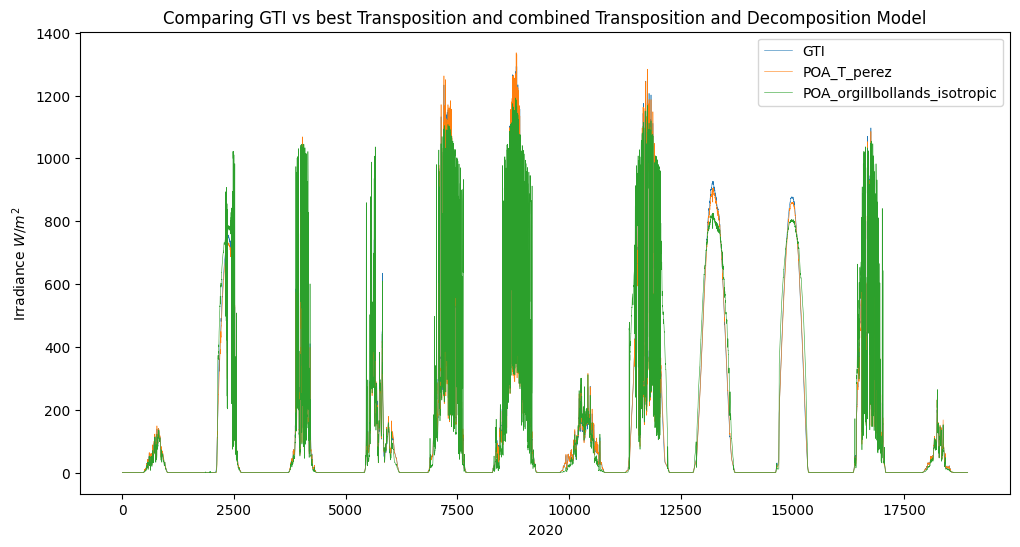

In [14]:
dates=['20200127','20200205','20200218','20200401','20200413','20200525','20200709','20200720','20200810','20200921','20200924','20201003']
GTI_T=calculate_irradiance_for_dates('LEEER',dates)
GTI_T = GTI_T[['GTI', 'POA_perez']].reset_index(drop=True)

GTI_D_T=calculate_decomposition_transposition_for_dates('LEEER',dates)
GTI_D_T = GTI_D_T[['GTI', 'POA_isotropic']].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the figsize as per your desired size
# Add axis labels
ax.set_xlabel('2020')
ax.set_ylabel('Irradiance $W/{m^2}$ ')
# Add a title
ax.set_title('Comparing GTI vs best Transposition and combined Transposition and Decomposition Model')
merged_df = GTI_T.merge(GTI_D_T, on='GTI')
merged_df.rename(columns={'POA_perez': 'POA_T_perez','POA_isotropic':'POA_orgillbollands_isotropic'}, inplace=True)
merged_df.plot(ax=ax,linewidth=0.4)

## Resutls

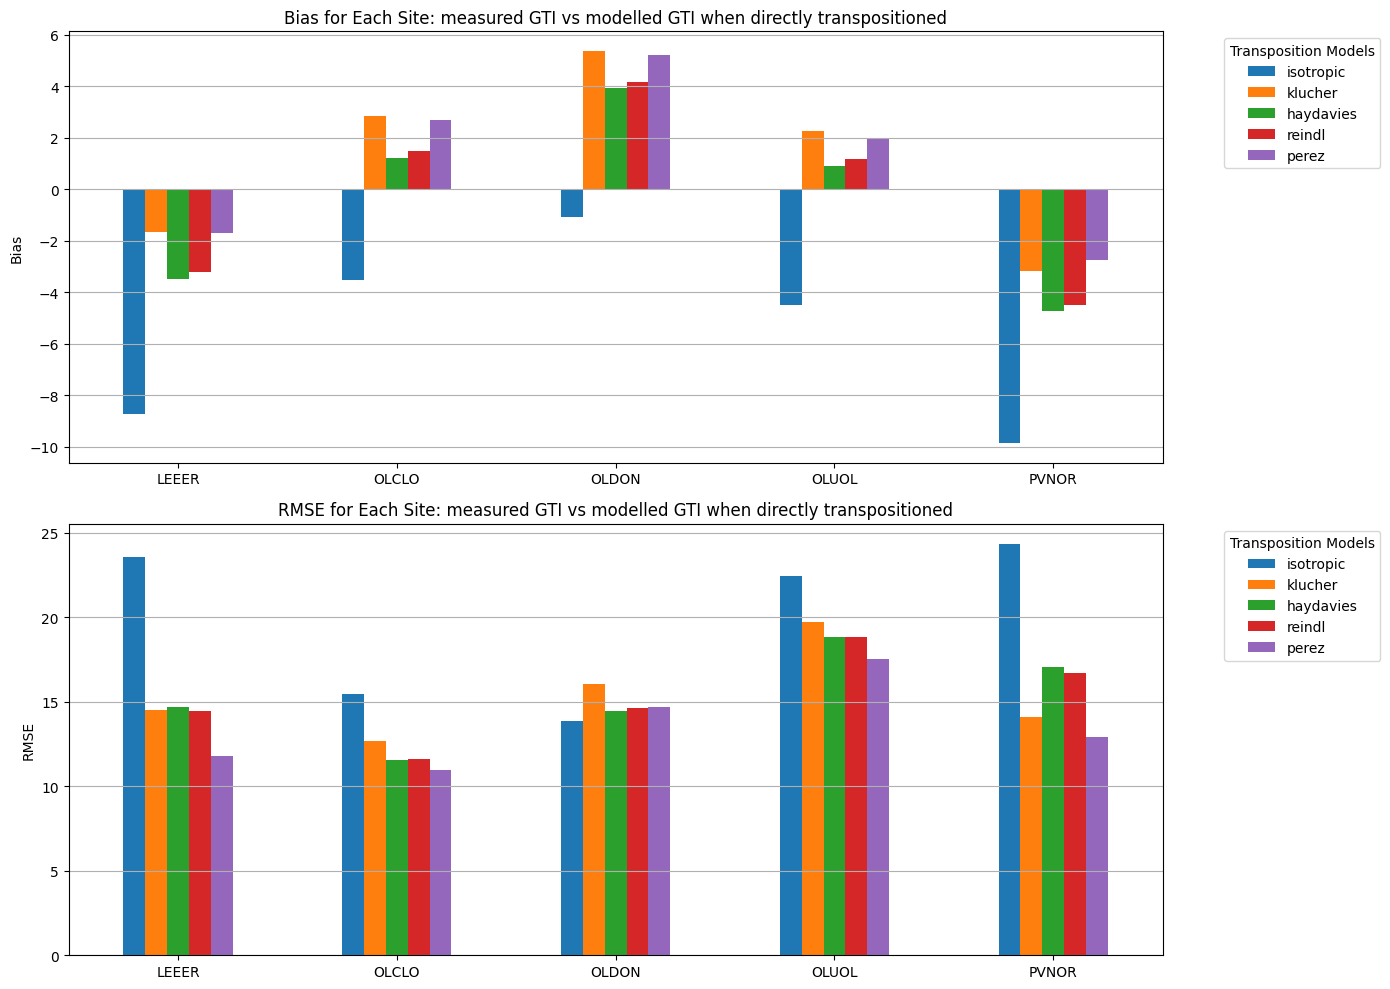

,bias_LEEER,rmse_LEEER,bias_OLCLO,rmse_OLCLO,bias_OLDON,rmse_OLDON,bias_OLUOL,rmse_OLUOL,bias_PVNOR,rmse_PVNOR
isotropic,-8.710306,23.592100,-3.512607,15.447943,-1.075903,13.882854,-4.474054,22.430652,-9.856644,24.324385
klucher,-1.663263,14.530953,2.843316,12.684896,5.374868,16.082924,2.264959,19.756116,-3.164268,14.108978
haydavies,-3.469085,14.692478,1.219593,11.581735,3.920920,14.440563,0.919424,18.834742,-4.740217,17.069013
reindl,-3.201748,14.468506,1.474055,11.615905,4.167377,14.639131,1.171583,18.867737,-4.474245,16.731825
perez,-1.707970,11.779971,2.693911,10.959286,5.220291,14.675077,2.003384,17.527193,-2.735131,12.910796


In [15]:
## Comparison of BIAS and RMSE when transpositioned with measured GHI, DHI, DNI

# Specify the folder and file path
folder_path = '../Project/Tables/'
file_name = 'Transposition_Error_matrix.csv'

# Load the CSV file from the specified folder
Transposition_Error_matrix = pd.read_csv(folder_path + file_name, index_col=0)

# Organize data into bias and rmse DataFrames
bias_df = Transposition_Error_matrix.filter(like='bias', axis=1)
rmse_df = Transposition_Error_matrix.filter(like='rmse', axis=1)

# Transpose the DataFrames
bias_df = bias_df.T
rmse_df = rmse_df.T

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Bias
bias_df.plot(kind='bar', ax=ax[0], title='Bias for Each Site: measured GTI vs modelled GTI when directly transpositioned')
ax[0].grid(axis='y')  # Add horizontal grid lines
ax[0].set_ylabel('Bias')
ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Transposition Models')  # Position legend outside
ax[0].set_xticklabels([label.split('_')[1] for label in bias_df.index], rotation=0)  

# RMSE
rmse_df.plot(kind='bar', ax=ax[1], title='RMSE for Each Site: measured GTI vs modelled GTI when directly transpositioned')
ax[1].grid(axis='y')  # Add horizontal grid lines
ax[1].set_ylabel('RMSE')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Transposition Models')  # Position legend outside
ax[1].set_xticklabels([label.split('_')[1] for label in rmse_df.index], rotation=0)  
plt.tight_layout()  

plt.savefig('../Project/Figures/' + 'Comparison_Error_Matrix_direct_transposition.png')
plt.show()

Transposition_Error_matrix


Text(0.5, 1.0, 'POA from Different Transposition Models and Measured GTI for LEEER on 20200810')

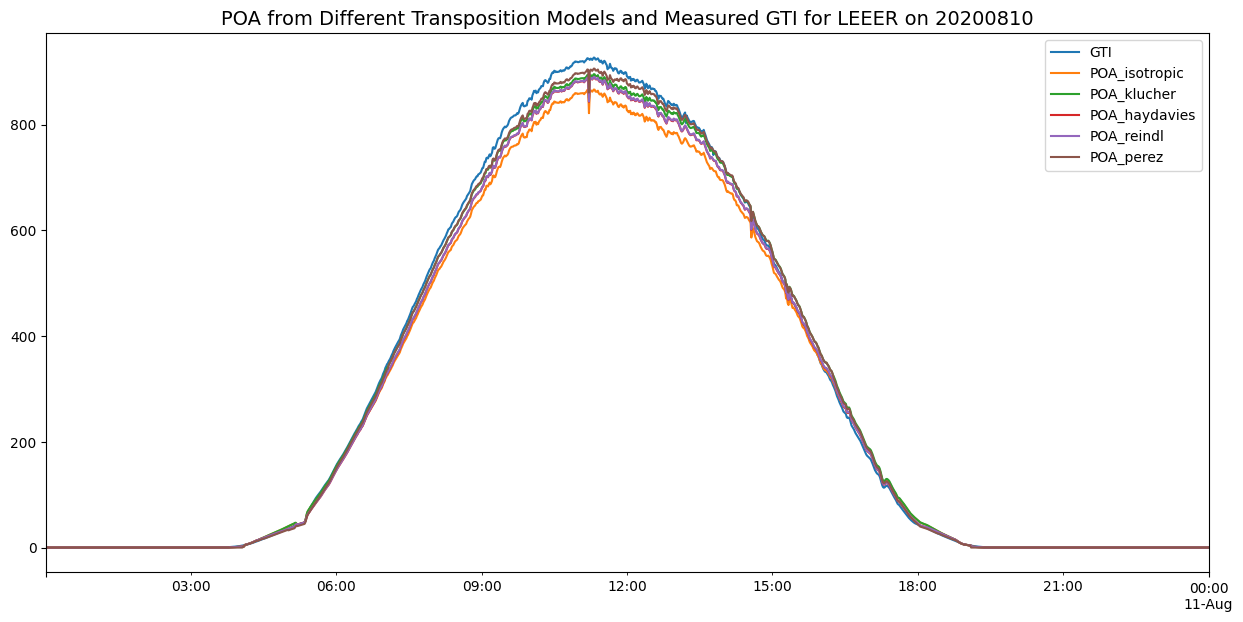

In [16]:
irradiance_data = get_transposition('LEEER', '20200810')

# Plotting all columns with specified linewidth
irradiance_data.plot(figsize=(15,7), linewidth=1.5)
plt.title("POA from Different Transposition Models and Measured GTI for LEEER on 20200810", fontsize=14)

In [17]:
Decomposition_Error_matrix_dhi

,bias_LEEER_dhi,rmse_LEEER_dhi,bias_OLCLO_dhi,rmse_OLCLO_dhi,bias_OLDON_dhi,rmse_OLDON_dhi,bias_OLUOL_dhi,rmse_OLUOL_dhi,bias_PVNOR_dhi,rmse_PVNOR_dhi
erbs,1.867235,40.591497,1.571997,38.588313,3.280094,36.018410,7.568606,39.811999,4.431513,40.640344
boland,-1.763889,52.711502,-2.552482,47.464860,-0.217293,45.875967,5.154760,50.379463,0.457170,49.737761
louche,4.302144,41.521160,4.917514,40.186783,6.199452,38.387113,7.626248,49.214039,7.666496,43.041729
orgill_hollands,1.063121,40.682967,1.096491,38.963018,2.743843,36.183296,7.048612,38.962010,3.862542,40.993197


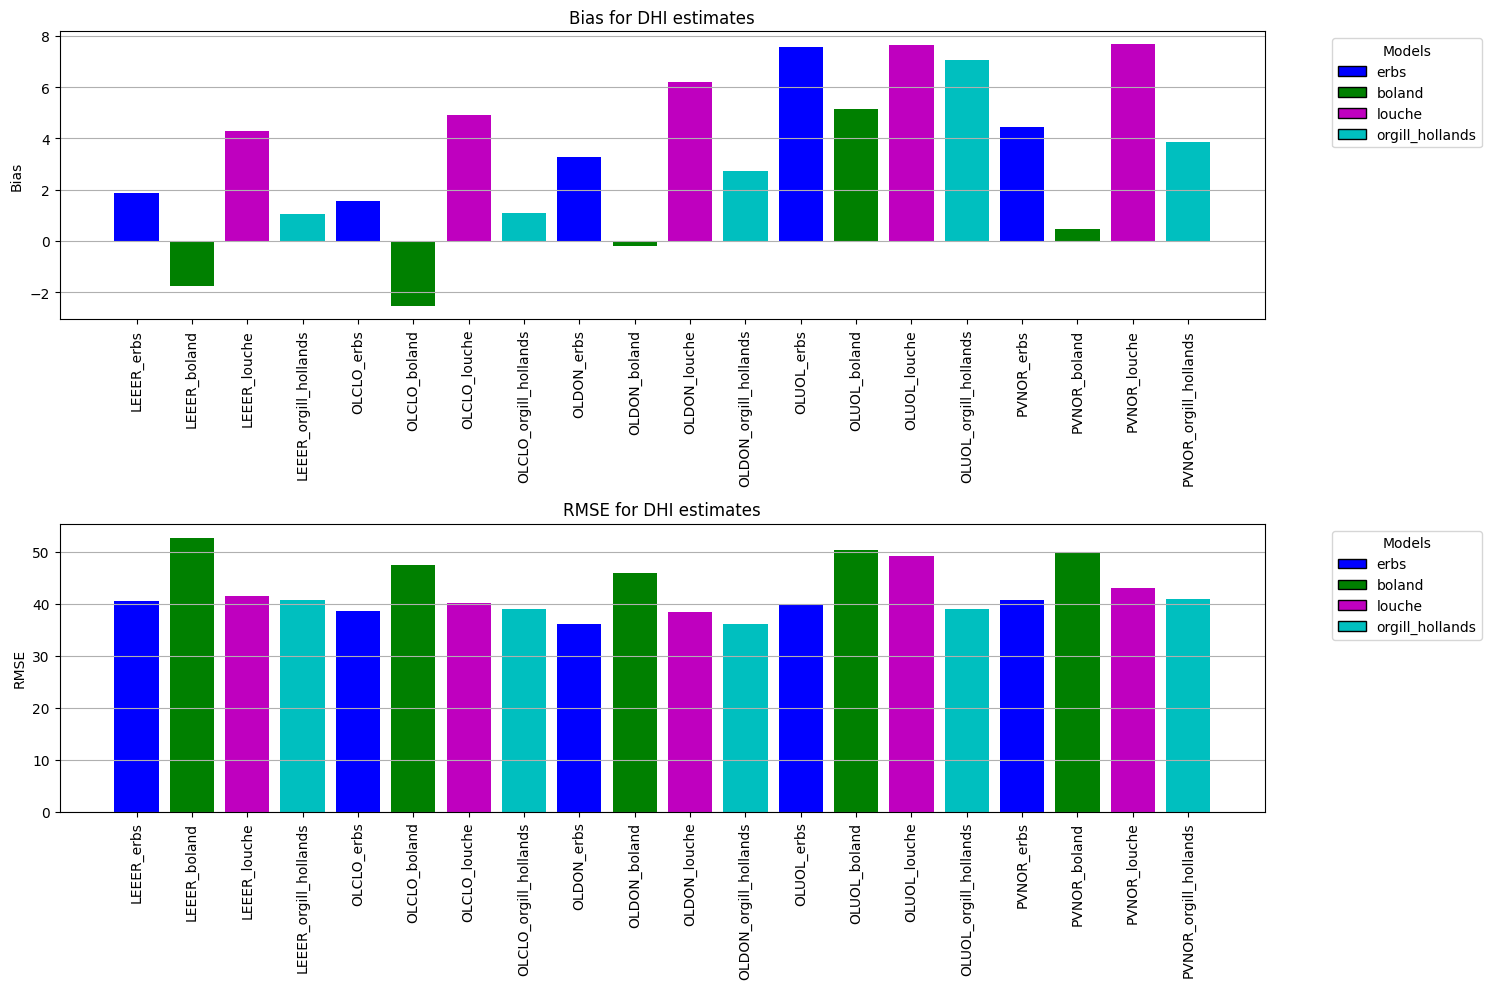

In [18]:
## Creating histogram of Bias and RMSE of DHI data

bias_dhim = [bias_LEEER_dhim1, bias_LEEER_dhim2, bias_LEEER_dhim3, bias_LEEER_dhim4, bias_OLCLO_dhim1, bias_OLCLO_dhim2, bias_OLCLO_dhim3, bias_OLCLO_dhim4, 
            bias_OLDON_dhim1, bias_OLDON_dhim2, bias_OLDON_dhim3, bias_OLDON_dhim4, bias_OLUOL_dhim1, bias_OLUOL_dhim2, bias_OLUOL_dhim3, bias_OLUOL_dhim4, 
            bias_PVNOR_dhim1, bias_PVNOR_dhim2, bias_PVNOR_dhim3, bias_PVNOR_dhim4]
rmse_dhim = [rmse_LEEER_dhim1, rmse_LEEER_dhim2, rmse_LEEER_dhim3, rmse_LEEER_dhim4, rmse_OLCLO_dhim1, rmse_OLCLO_dhim2, rmse_OLCLO_dhim3, rmse_OLCLO_dhim4, 
            rmse_OLDON_dhim1, rmse_OLDON_dhim2, rmse_OLDON_dhim3, rmse_OLDON_dhim4, rmse_OLUOL_dhim1, rmse_OLUOL_dhim2, rmse_OLUOL_dhim3, rmse_OLUOL_dhim4, 
            rmse_PVNOR_dhim1, rmse_PVNOR_dhim2, rmse_PVNOR_dhim3, rmse_PVNOR_dhim4]

# Create list of labels
labels = ['LEEER_erbs', 'LEEER_boland', 'LEEER_louche', 'LEEER_orgill_hollands', 'OLCLO_erbs', 'OLCLO_boland', 'OLCLO_louche', 'OLCLO_orgill_hollands', 'OLDON_erbs', 'OLDON_boland', 'OLDON_louche', 'OLDON_orgill_hollands', 'OLUOL_erbs', 'OLUOL_boland', 'OLUOL_louche', 'OLUOL_orgill_hollands', 'PVNOR_erbs', 'PVNOR_boland', 'PVNOR_louche', 'PVNOR_orgill_hollands']

x = range(len(labels))

# Define the color scheme
colors = ['b', 'g', 'm', 'c']  
models = ['erbs', 'boland', 'louche', 'orgill_hollands']  # Models names

# Create color list for the bias and rmse
bias_colors = colors[:len(models)] * (len(bias_dhim) // len(models))
rmse_colors = colors[:len(models)] * (len(rmse_dhim) // len(models))

# Create 2 subplots: one for bias, one for RMSE
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].bar(x, bias_dhim, color=bias_colors, tick_label=labels)
ax[0].set_title('Bias for DHI estimates')
ax[0].set_ylabel('Bias')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation='vertical')
ax[0].grid(True, axis='y')

ax[1].bar(x, rmse_dhim, color=rmse_colors, tick_label=labels)
ax[1].set_title('RMSE for DHI estimates')
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation='vertical')
ax[1].grid(True, axis='y')

# Creating Proxy Artists for the legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=clr, edgecolor='k', label=model) 
                   for clr, model in zip(colors, models)]


# Adding legend to the plots outside
ax[0].legend(handles=legend_elements, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(handles=legend_elements, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [19]:
Decomposition_Error_matrix_dni

,bias_LEEER_dni,rmse_LEEER_dni,bias_OLCLO_dni,rmse_OLCLO_dni,bias_OLDON_dni,rmse_OLDON_dni,bias_OLUOL_dni,rmse_OLUOL_dni,bias_PVNOR_dni,rmse_PVNOR_dni
erbs,-1.101461,82.404428,-0.125256,80.276940,-4.488152,76.452082,-13.228099,78.516821,-7.684244,84.742821
boland,7.587934,103.358192,9.481867,95.857298,4.098300,92.407259,-6.286161,94.591889,1.317144,101.090343
louche,-7.572455,81.662008,-8.381269,80.915528,-11.993497,78.861047,-16.504864,89.511656,-15.057647,86.755699
orgill_hollands,-0.182233,82.654730,0.312178,80.530993,-3.884752,76.469822,-12.562301,77.165013,-7.020253,84.683119


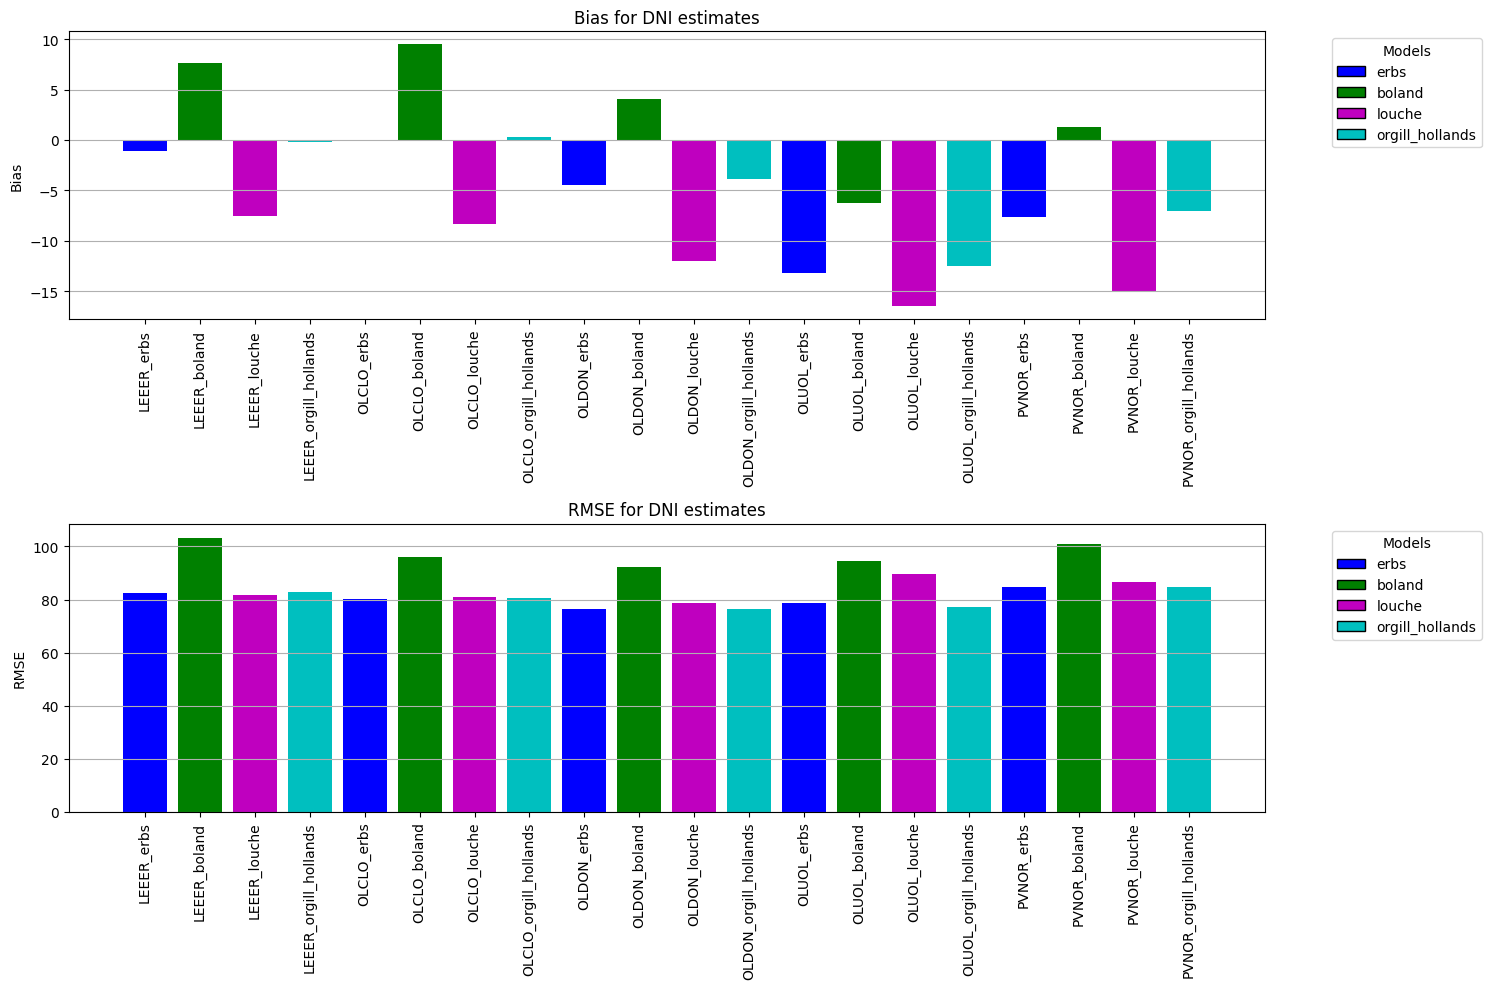

In [20]:
## Creating histogram of Bias and RMSE of DNI data

bias_dni = [bias_LEEER_dnim1, bias_LEEER_dnim2, bias_LEEER_dnim3, bias_LEEER_dnim4, bias_OLCLO_dnim1, bias_OLCLO_dnim2, bias_OLCLO_dnim3, bias_OLCLO_dnim4, 
            bias_OLDON_dnim1, bias_OLDON_dnim2, bias_OLDON_dnim3, bias_OLDON_dnim4, bias_OLUOL_dnim1, bias_OLUOL_dnim2, bias_OLUOL_dnim3, bias_OLUOL_dnim4, 
            bias_PVNOR_dnim1, bias_PVNOR_dnim2, bias_PVNOR_dnim3, bias_PVNOR_dnim4]
rmse_dni = [rmse_LEEER_dnim1, rmse_LEEER_dnim2, rmse_LEEER_dnim3, rmse_LEEER_dnim4, rmse_OLCLO_dnim1, rmse_OLCLO_dnim2, rmse_OLCLO_dnim3, rmse_OLCLO_dnim4,
            rmse_OLDON_dnim1, rmse_OLDON_dnim2, rmse_OLDON_dnim3, rmse_OLDON_dnim4, rmse_OLUOL_dnim1, rmse_OLUOL_dnim2, rmse_OLUOL_dnim3, rmse_OLUOL_dnim4, 
            rmse_PVNOR_dnim1, rmse_PVNOR_dnim2, rmse_PVNOR_dnim3, rmse_PVNOR_dnim4]

# Create list of labels
labels = ['LEEER_erbs', 'LEEER_boland', 'LEEER_louche', 'LEEER_orgill_hollands', 'OLCLO_erbs', 'OLCLO_boland', 'OLCLO_louche', 'OLCLO_orgill_hollands', 'OLDON_erbs', 'OLDON_boland', 'OLDON_louche', 'OLDON_orgill_hollands', 'OLUOL_erbs', 'OLUOL_boland', 'OLUOL_louche', 'OLUOL_orgill_hollands', 'PVNOR_erbs', 'PVNOR_boland', 'PVNOR_louche', 'PVNOR_orgill_hollands']

x = range(len(labels))

# Define the color scheme
colors = ['b', 'g', 'm', 'c']  
models = ['erbs', 'boland', 'louche', 'orgill_hollands']  # Models names

# Create color list for the bias and rmse
bias_colors = colors[:len(models)] * (len(bias_dni) // len(models))
rmse_colors = colors[:len(models)] * (len(rmse_dni) // len(models))

# Create 2 subplots: one for bias, one for RMSE
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].bar(x, bias_dni, color=bias_colors, tick_label=labels)
ax[0].set_title('Bias for DNI estimates')
ax[0].set_ylabel('Bias')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation='vertical')
ax[0].grid(True, axis='y')

ax[1].bar(x, rmse_dni, color=rmse_colors, tick_label=labels)
ax[1].set_title('RMSE for DNI estimates')
ax[1].set_ylabel('RMSE')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation='vertical')
ax[1].grid(True, axis='y')

# Creating Proxy Artists for the legend
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=clr, edgecolor='k', label=model) 
                   for clr, model in zip(colors, models)]


# Adding legend to the plots outside
ax[0].legend(handles=legend_elements, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
ax[1].legend(handles=legend_elements, title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

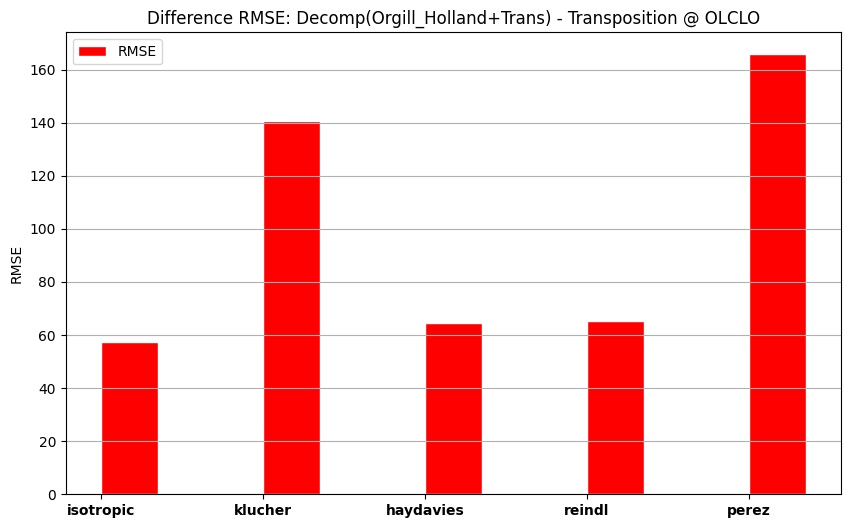

,bias_LEEER,rmse_LEEER,bias_OLCLO,rmse_OLCLO,bias_OLDON,rmse_OLDON,bias_OLUOL,rmse_OLUOL,bias_PVNOR,rmse_PVNOR
isotropic,21.358741,56.929242,15.267481,57.426182,18.214914,65.611639,24.507149,67.538932,22.920882,63.542619
klucher,-33.750516,172.425994,-33.860680,140.566247,-38.165200,157.341322,-46.877521,199.700641,-34.972703,180.181022
haydavies,21.704339,68.305463,16.011400,64.614540,18.719713,69.859339,24.707502,75.801187,23.367169,73.995596
reindl,22.204028,69.401665,16.431566,65.424583,19.164683,70.636902,25.199278,76.766284,23.834200,75.129657
perez,59.704890,192.473231,49.644416,165.754951,57.580564,188.885734,79.083583,294.703716,65.035506,242.695104


In [21]:
# Specify the folder and file path
folder_path = '../Project/Tables/'
file_name1 = 'Transposition_Error_matrix.csv'
file_name2 = 'Transposition_and_Decomposition_orgill_hollands_Error_matrix.csv'

# Load the CSV file from the specified folder
Transposition_Error_matrix = pd.read_csv(folder_path + file_name1, index_col=0)
Transposition_and_Decomposition_orgill_hollands_Error_matrix = pd.read_csv(folder_path + file_name2, index_col=0)

# Subtract the DataFrames
Difference_Error_matrix = Transposition_and_Decomposition_orgill_hollands_Error_matrix - Transposition_Error_matrix

# Define site and the methods
site = 'OLCLO'
methods = Difference_Error_matrix.index

# differences_bias = [Difference_Error_matrix[f'bias_{site}'][method] for method in methods]
differences_rmse = [Difference_Error_matrix[f'rmse_{site}'][method] for method in methods]

# Create a new figure
plt.figure(figsize=(10, 6))

# The x locations for the groups
ind = np.arange(len(methods))

# The width of the bars
width = 0.35  

# Create the bar plot
# plt.bar(ind - width/2, differences_bias, width, color='b', edgecolor='white', label='Bias')
plt.bar(ind + width/2, differences_rmse, width, color='r', edgecolor='white', label='RMSE')

# Custom X axis
plt.xticks(ind, methods, fontweight='bold')
plt.title(f"Difference RMSE: Decomp(Orgill_Holland+Trans) - Transposition @ {site}")
plt.ylabel(f"RMSE")
plt.grid(axis='y')   

# Add a legend
plt.legend()

# Show the plot
plt.show()
Difference_Error_matrix

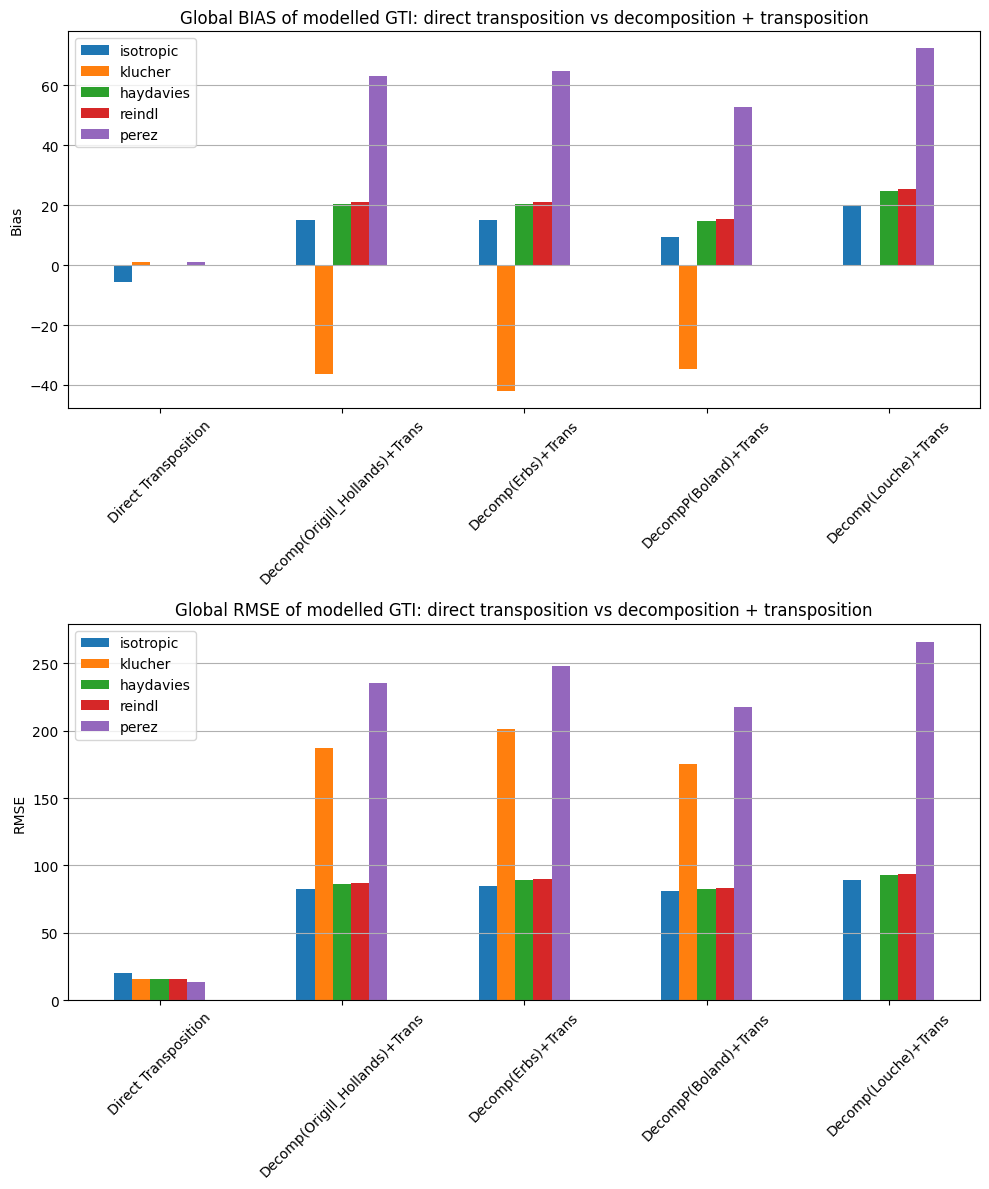

Direct Transposition            Decomp(Origill_Hollands)+Trans  \
                          bias       rmse                           bias   
isotropic            -5.525903  20.409653                      14.927931   
klucher               1.131122  15.621031                     -36.394202   
haydavies            -0.429873  15.521817                      20.472151   
reindl               -0.172596  15.456497                      21.194155   
perez                 1.094571  13.770423                      63.308379   

                      Decomp(Erbs)+Trans             DecompP(Boland)+Trans  \
                 rmse               bias        rmse                  bias   
isotropic   82.375768          15.007577   84.947108              9.435040   
klucher    186.775081         -41.886800  201.432512            -34.575323   
haydavies   86.081039          20.262656   88.841212             14.768410   
reindl      86.977977          20.966589   89.750571             15.424425   
perez      235.459896          64.970386  248.003332             52.769279   

                      Decomp(Louche)+Trans              
                 rmse                 bias        rmse  
isotropic   80.892066            19.616024   89.017393  
klucher    175.590084                  inf         inf  
haydavies   82.849879            24.740677   92.710569  
reindl      83.572729            25.461112   93.605864  
perez      217.417803            72.375634  265.946015

In [22]:
## Comparison of global error matrics

import pandas as pd
import matplotlib.pyplot as plt

# Specify the folder and file path
folder_path = '../Project/Tables/'
file_name1 = 'Allsites_Transposition_Error_matrix.csv'
file_name2 = 'Allsites_Decomposition_orgill_hollands_and_Transposition_Error_Matrix.csv'
file_name3 = 'Allsites_Decomposition_erbs_and_Transposition_Error_Matrix.csv'
file_name4 = 'Allsites_Decomposition_boland_and_Transposition_Error_Matrix.csv'
file_name5 = 'Allsites_Decomposition_louche_and_Transposition_Error_Matrix.csv'

# Load the CSV files from the specified folder
glob_df1 = pd.read_csv(folder_path + file_name1, index_col=0)
glob_df2 = pd.read_csv(folder_path + file_name2, index_col=0)
glob_df3 = pd.read_csv(folder_path + file_name3, index_col=0)
glob_df4 = pd.read_csv(folder_path + file_name4, index_col=0)
glob_df5 = pd.read_csv(folder_path + file_name5, index_col=0)

# Combine the two DataFrames side by side
Global_comprasion = pd.concat([glob_df1, glob_df2, glob_df3, glob_df4, glob_df5], axis=1, keys=['Direct Transposition', 'Decomp(Origill_Hollands)+Trans','Decomp(Erbs)+Trans','DecompP(Boland)+Trans','Decomp(Louche)+Trans'])

# Filter for 'bias' and 'rmse'
bias_df = Global_comprasion.xs('bias', level=1, axis=1)  
rmse_df = Global_comprasion.xs('rmse', level=1, axis=1)  

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10,12))

# Plot for bias
bias_df.T.plot(kind='bar', ax=axs[0], title='Global BIAS of modelled GTI: direct transposition vs decomposition + transposition')
axs[0].grid(axis='y')  # Add horizontal grid lines
axs[0].set_ylabel('Bias')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)  # To avoid overlapping labels

# Plot for rmse
rmse_df.T.plot(kind='bar', ax=axs[1], title='Global RMSE of modelled GTI: direct transposition vs decomposition + transposition')
axs[1].grid(axis='y')  # Add horizontal grid lines
axs[1].set_ylabel('RMSE')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)  # To avoid overlapping labels

# Adjust layout and save
plt.tight_layout()
plt.savefig('../Project/Figures/'+'Comparison_Global_error_matrics.png')
plt.show()

Global_comprasion